In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
import torch.optim as optim
from pathlib import Path
import matplotlib.pyplot as plt
from torchsummary import summary
import time
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
!mkdir data
data_dir = Path('./data')
net_fn = Path('./net')
import math
torch.manual_seed(0)
np.random.seed(0)
from prettytable import PrettyTable
!pip install pthflops
from pthflops import count_ops
import copy
!pip install torchinfo
import torchinfo
!pip install thop
from thop import profile
torch.manual_seed(0)
np.random.seed(0)
!pip install --upgrade efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
from scipy.linalg import svd

PyTorch Version:  1.13.0+cu116
Torchvision Version:  0.14.0+cu116
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=f63aba263f8519c5b43687e1eae6c7e7add07601628ce6f956cb2a4498f78ce4
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
Successfully built efficientnet-pytorch


In [46]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Mount data directory to google drive
"""
Used the comments in code to execute the file, when used with an account 
that has access to the shared folder of the class, the code will automatically run
"""
from google.colab import drive
drive.mount('./drive')

# Copy to local for faster extraction
!cp drive/Shareddrives/penn-ese-5390-202230/ILSVRC2012_img_val.tar ./data
!cp drive/Shareddrives/penn-ese-5390-202230/ILSVRC2012_devkit_t3.tar.gz ./data
!cp drive/Shareddrives/penn-ese-5390-202230/ILSVRC2012_devkit_t12.tar.gz ./data

# Create transform to preprocess data
val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# from google.colab import drive
# drive.mount('/content/drive')

# # Copy to local for faster extraction
# !cp /content/drive/Shareddrives/539/ILSVRC2012_img_val.tar ./data
# !cp /content/drive/Shareddrives/539/ILSVRC2012_devkit_t3.tar.gz ./data
# !cp /content/drive/Shareddrives/539/ILSVRC2012_devkit_t12.tar.gz ./data

# val_transform = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# Create validation dataset
val_dataset = datasets.ImageNet('./data', split='val', transform=val_transform)

# Create validation dataloader
val_dataloader = torch.utils.data.DataLoader(val_dataset, num_workers=4)

print(f'Number of validation images: {len(val_dataset)}')


Mounted at /content/drive
Number of validation images: 50000


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [29]:
def validate_model(model, dataloader, device="cpu", n=None):
    model.eval()
    running_corrects = 0
    total = 0

    # Move model to device (CPU or GPU)
    # One time to amortize data movement
    dev = torch.device(device)
    model.to(dev)

    # Iterate over data stopping early if n is set
    for i, (inputs, labels) in enumerate(dataloader):
        if (n is not None and i >= n):
            break
        # Send inputs to device
        inputs = inputs.to(dev)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        """
        """
        temp = labels.data
        if(device=="cuda"):
          temp = temp.to(device="cuda")


        # Gather statistics
        running_corrects += torch.sum(predicted == temp)
        total += inputs.size()[0]       # get batch size

        if i % 200 == 199:
            acc = 100 * running_corrects.double() / total
            print(f'[{i + 1}] {acc:.4f}%')

    epoch_acc = 100 * running_corrects.double() / total

    return epoch_acc


In [47]:
def compare_models(model_1, model_2):
    # Move models to specified device
    model_1 = model_1.to(dev)
    model_2 = model_2.to(dev)
    
    # Initialize counter for number of differences between models
    models_differ = 0
    
    # Iterate over keys and values of state dictionaries in parallel
    for key_1, value_1, key_2, value_2 in zip(model_1.state_dict().keys(), model_1.state_dict().values(), model_2.state_dict().keys(), model_2.state_dict().values()):
        # If keys are not the same, raise exception
        if key_1 != key_2:
            raise Exception('Mismatch in keys of model state dictionaries')
        # If values are not equal, check if key contains 'weight' and increment counter
        if not torch.equal(value_1, value_2):
            if 'weight' not in key_1:
                models_differ += 1
                print('Mismatch found at', key_1)
    # If counter is 0, print message indicating models match perfectly
    if models_differ == 0:
        print('Models match perfectly! :)')


In [48]:
def count_parameters(model):
  
    table = PrettyTable(["Modules", "Parameters"])# Initialize table and total parameter count
    total_params = 0
    for name, parameter in model.named_parameters(): # Iterate over model's named parameters
        if not parameter.requires_grad: continue # Skip parameters that do not require gradients
        params = parameter.numel()# Get number of parameters and add to table and total count
        table.add_row([name, params])
        total_params+=params
    # print(table)
    # print(f"Total Trainable Params: {total_params}")
    return total_params

In [49]:
def _flops(layer, ip):
    input = torch.randn(1, ip, 224, 224) # Generate random input tensor
    flops, params = profile(layer, inputs=input) # Calculate FLOPS and number of parameters for the layer
    return flops

In [50]:
model_mobilenet = models.mobilenet_v2(pretrained=True)
model_mobilenet = model_mobilenet.to(dev)
# summary(model_mobilenet, input_size = (3,224,224))

In [51]:
print(torchinfo.summary(model_mobilenet, (3, 224, 224), batch_dim = 0, col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0))

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
MobileNetV2                                        [1, 3, 224, 224]          [1, 1000]                 --                        --                        --
├─Sequential: 1-1                                  [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        --                        --
│    └─Conv2dNormActivation: 2-1                   [1, 3, 224, 224]          [1, 32, 112, 112]         --                        --                        --
│    │    └─Conv2d: 3-1                            [1, 3, 224, 224]          [1, 32, 112, 112]         864                       [3, 3]                    10,838,016
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         [1, 32, 112, 112]         64                        --                        64
│    │    └─ReLU6: 3-3               

The following code is simulating image scaling for phi values from 0 to 7.

In [52]:
"""
phi = 0
"""
ip = torch.rand(1,3,224,224).to(dev)
temp = count_ops(model_mobilenet, ip) # Count the number of FLOPs

Operation              OPS        
---------------------  ---------  
features_0_0           10838016   
features_0_1           802816     
features_1_conv_0_0    3612672    
features_1_conv_0_1    802816     
features_1_conv_1      6422528    
features_1_conv_2      401408     
features_2_conv_0_0    19267584   
features_2_conv_0_1    2408448    
features_2_conv_1_0    2709504    
features_2_conv_1_1    602112     
features_2_conv_2      7225344    
features_2_conv_3      150528     
features_3_conv_0_0    10838016   
features_3_conv_0_1    903168     
features_3_conv_1_0    4064256    
features_3_conv_1_1    903168     
features_3_conv_2      10838016   
features_3_conv_3      150528     
add                    150528     
features_4_conv_0_0    10838016   
features_4_conv_0_1    903168     
features_4_conv_1_0    1016064    
features_4_conv_1_1    225792     
features_4_conv_2      3612672    
features_4_conv_3      50176      
features_5_conv_0_0    4816896    
features_5_conv_0_1 

In [53]:
"""
phi = 1
"""
phi = 1
mul = math.pow(math.sqrt(2),phi)
ip = torch.rand(1,3,math.ceil(mul*224),math.ceil(mul*224)).to(dev)
temp = count_ops(model_mobilenet, ip) # Count the number of FLOPs

Operation              OPS        
---------------------  ---------  
features_0_0           21842784   
features_0_1           1617984    
features_1_conv_0_0    7280928    
features_1_conv_0_1    1617984    
features_1_conv_1      12943872   
features_1_conv_2      808992     
features_2_conv_0_0    38831616   
features_2_conv_0_1    4853952    
features_2_conv_1_0    5529600    
features_2_conv_1_1    1228800    
features_2_conv_2      14745600   
features_2_conv_3      307200     
features_3_conv_0_0    22118400   
features_3_conv_0_1    1843200    
features_3_conv_1_0    8294400    
features_3_conv_1_1    1843200    
features_3_conv_2      22118400   
features_3_conv_3      307200     
add                    307200     
features_4_conv_0_0    22118400   
features_4_conv_0_1    1843200    
features_4_conv_1_0    2073600    
features_4_conv_1_1    460800     
features_4_conv_2      7372800    
features_4_conv_3      102400     
features_5_conv_0_0    9830400    
features_5_conv_0_1 

In [54]:
"""
phi = 2
"""
phi = 2
mul = math.pow(math.sqrt(2),phi)
ip = torch.rand(1,3,math.ceil(mul*224),math.ceil(mul*224)).to(dev)
temp = count_ops(model_mobilenet, ip) # Count the number of FLOPs

Operation              OPS        
---------------------  ---------  
features_0_0           43740000   
features_0_1           3240000    
features_1_conv_0_0    14580000   
features_1_conv_0_1    3240000    
features_1_conv_1      25920000   
features_1_conv_2      1620000    
features_2_conv_0_0    77760000   
features_2_conv_0_1    9720000    
features_2_conv_1_0    11032416   
features_2_conv_1_1    2451648    
features_2_conv_2      29419776   
features_2_conv_3      612912     
features_3_conv_0_0    44129664   
features_3_conv_0_1    3677472    
features_3_conv_1_0    16548624   
features_3_conv_1_1    3677472    
features_3_conv_2      44129664   
features_3_conv_3      612912     
add                    612912     
features_4_conv_0_0    44129664   
features_4_conv_0_1    3677472    
features_4_conv_1_0    4210704    
features_4_conv_1_1    935712     
features_4_conv_2      14971392   
features_4_conv_3      207936     
features_5_conv_0_0    19961856   
features_5_conv_0_1 

In [55]:
"""
phi = 3
"""
phi = 3
mul = math.pow(math.sqrt(2),phi)
ip = torch.rand(1,3,math.ceil(mul*224),math.ceil(mul*224)).to(dev)
temp = count_ops(model_mobilenet, ip) # Count the number of FLOPs

Operation              OPS         
---------------------  ----------  
features_0_0           86822496    
features_0_1           6431296     
features_1_conv_0_0    28940832    
features_1_conv_0_1    6431296     
features_1_conv_1      51450368    
features_1_conv_2      3215648     
features_2_conv_0_0    154351104   
features_2_conv_0_1    19293888    
features_2_conv_1_0    21842784    
features_2_conv_1_1    4853952     
features_2_conv_2      58247424    
features_2_conv_3      1213488     
features_3_conv_0_0    87371136    
features_3_conv_0_1    7280928     
features_3_conv_1_0    32764176    
features_3_conv_1_1    7280928     
features_3_conv_2      87371136    
features_3_conv_3      1213488     
add                    1213488     
features_4_conv_0_0    87371136    
features_4_conv_0_1    7280928     
features_4_conv_1_0    8294400     
features_4_conv_1_1    1843200     
features_4_conv_2      29491200    
features_4_conv_3      409600      
features_5_conv_0_0    39321

In [56]:
"""
phi = 4
"""
phi = 4
mul = math.pow(math.sqrt(2),phi)
ip = torch.rand(1,3,math.ceil(mul*224),math.ceil(mul*224)).to(dev)
temp = count_ops(model_mobilenet, ip) # Count the number of FLOPs

Operation              OPS         
---------------------  ----------  
features_0_0           174183264   
features_0_1           12902464    
features_1_conv_0_0    58061088    
features_1_conv_0_1    12902464    
features_1_conv_1      103219712   
features_1_conv_2      6451232     
features_2_conv_0_0    309659136   
features_2_conv_0_1    38707392    
features_2_conv_1_0    43740000    
features_2_conv_1_1    9720000     
features_2_conv_2      116640000   
features_2_conv_3      2430000     
features_3_conv_0_0    174960000   
features_3_conv_0_1    14580000    
features_3_conv_1_0    65610000    
features_3_conv_1_1    14580000    
features_3_conv_2      174960000   
features_3_conv_3      2430000     
add                    2430000     
features_4_conv_0_0    174960000   
features_4_conv_0_1    14580000    
features_4_conv_1_0    16548624    
features_4_conv_1_1    3677472     
features_4_conv_2      58839552    
features_4_conv_3      817216      
features_5_conv_0_0    78452

In [57]:
"""
phi = 5
"""
phi = 5
mul = math.pow(math.sqrt(2),phi)
ip = torch.rand(1,3,math.ceil(mul*224),math.ceil(mul*224)).to(dev)
temp = count_ops(model_mobilenet, ip) # Count the number of FLOPs

Operation              OPS         
---------------------  ----------  
features_0_0           347289984   
features_0_1           25725184    
features_1_conv_0_0    115763328   
features_1_conv_0_1    25725184    
features_1_conv_1      205801472   
features_1_conv_2      12862592    
features_2_conv_0_0    617404416   
features_2_conv_0_1    77175552    
features_2_conv_1_0    86822496    
features_2_conv_1_1    19293888    
features_2_conv_2      231526656   
features_2_conv_3      4823472     
features_3_conv_0_0    347289984   
features_3_conv_0_1    28940832    
features_3_conv_1_0    130233744   
features_3_conv_1_1    28940832    
features_3_conv_2      347289984   
features_3_conv_3      4823472     
add                    4823472     
features_4_conv_0_0    347289984   
features_4_conv_0_1    28940832    
features_4_conv_1_0    32764176    
features_4_conv_1_1    7280928     
features_4_conv_2      116494848   
features_4_conv_3      1617984     
features_5_conv_0_0    15532

In [58]:
"""
phi = 6
"""
phi = 6
mul = math.pow(math.sqrt(2),phi)
ip = torch.rand(1,3,math.ceil(mul*224),math.ceil(mul*224)).to(dev)
temp = count_ops(model_mobilenet, ip) # Count the number of FLOPs

Operation              OPS          
---------------------  -----------  
features_0_0           695182176    
features_0_1           51494976     
features_1_conv_0_0    231727392    
features_1_conv_0_1    51494976     
features_1_conv_1      411959808    
features_1_conv_2      25747488     
features_2_conv_0_0    1235879424   
features_2_conv_0_1    154484928    
features_2_conv_1_0    174183264    
features_2_conv_1_1    38707392     
features_2_conv_2      464488704    
features_2_conv_3      9676848      
features_3_conv_0_0    696733056    
features_3_conv_0_1    58061088     
features_3_conv_1_0    261274896    
features_3_conv_1_1    58061088     
features_3_conv_2      696733056    
features_3_conv_3      9676848      
add                    9676848      
features_4_conv_0_0    696733056    
features_4_conv_0_1    58061088     
features_4_conv_1_0    65610000     
features_4_conv_1_1    14580000     
features_4_conv_2      233280000    
features_4_conv_3      3240000      
f

In [59]:
"""
phi = 7
"""
phi = 7
mul = math.pow(math.sqrt(2),phi)
ip = torch.rand(1,3,math.ceil(mul*224),math.ceil(mul*224)).to(dev)
temp = count_ops(model_mobilenet, ip) # Count the number of FLOPs

Operation              OPS          
---------------------  -----------  
features_0_0           1389159936   
features_0_1           102900736    
features_1_conv_0_0    463053312    
features_1_conv_0_1    102900736    
features_1_conv_1      823205888    
features_1_conv_2      51450368     
features_2_conv_0_0    2469617664   
features_2_conv_0_1    308702208    
features_2_conv_1_0    347289984    
features_2_conv_1_1    77175552     
features_2_conv_2      926106624    
features_2_conv_3      19293888     
features_3_conv_0_0    1389159936   
features_3_conv_0_1    115763328    
features_3_conv_1_0    520934976    
features_3_conv_1_1    115763328    
features_3_conv_2      1389159936   
features_3_conv_3      19293888     
add                    19293888     
features_4_conv_0_0    1389159936   
features_4_conv_0_1    115763328    
features_4_conv_1_0    130233744    
features_4_conv_1_1    28940832     
features_4_conv_2      463053312    
features_4_conv_3      6431296      
f

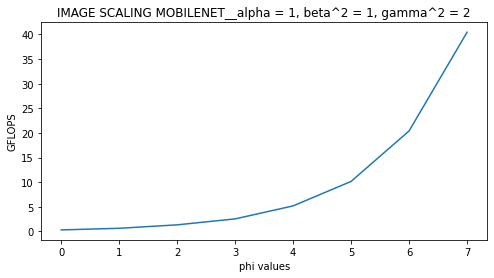

In [65]:
y = [0.31,0.64,1.34,2.55,5.19,10.16,20.40,40.44] #plotting results in a graph
x = [0,1,2,3,4,5,6,7]
plt.figure(figsize = (8,4))
plt.title("IMAGE SCALING MOBILENET__alpha = 1, beta^2 = 1, gamma^2 = 2")
plt.xlabel("phi values")
plt.ylabel("GFLOPS")
plt.plot(x,y)


In [60]:
net_m = copy.deepcopy(model_mobilenet)
for name, child in net_m.named_children():
  print(name)


features
classifier


In [61]:
net_m.features[0][0] = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
net_m.features[0][1] = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[0][2] = nn.ReLU6(inplace=True)



net_m.features[1].conv[0][0] = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
net_m.features[1].conv[0][1] = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[1].conv[0][2] = nn.ReLU6(inplace=True)
net_m.features[1].conv[1] = nn.Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[1].conv[2] = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)





net_m.features[2].conv[0][0] = nn.Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[2].conv[0][1] = nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[2].conv[0][2] = nn.ReLU6(inplace=True)
net_m.features[2].conv[1][0] = nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=96, bias=False)
net_m.features[2].conv[1][1] = nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[2].conv[1][2] = nn.ReLU6(inplace=True)
net_m.features[2].conv[2] = nn.Conv2d(96, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[2].conv[3] = nn.BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)





net_m.features[3].conv[0][0] = nn.Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[3].conv[0][1] = nn.BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[3].conv[0][2] = nn.ReLU6(inplace=True)
net_m.features[3].conv[1][0] = nn.Conv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=144, bias=False)
net_m.features[3].conv[1][1] = nn.BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[3].conv[1][2] = nn.ReLU6(inplace=True)
net_m.features[3].conv[2] = nn.Conv2d(144, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[3].conv[3] = nn.BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


net_m.features[4].conv[0][0] = nn.Conv2d(144, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[4].conv[0][1] = nn.BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[4].conv[0][2] = nn.ReLU6(inplace=True)
net_m.features[4].conv[1][0] = nn.Conv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=144, bias=False)
net_m.features[4].conv[1][1] = nn.BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[4].conv[1][2] = nn.ReLU6(inplace=True)
net_m.features[4].conv[2] = nn.Conv2d(144, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[4].conv[3] = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)




net_m.features[5].conv[0][0] = nn.Conv2d(32, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[5].conv[0][1] = nn.BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[5].conv[0][2] = nn.ReLU6(inplace=True)
net_m.features[5].conv[1][0] = nn.Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=192, bias=False)
net_m.features[5].conv[1][1] = nn.BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[5].conv[1][2] = nn.ReLU6(inplace=True)
net_m.features[5].conv[2] = nn.Conv2d(192, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[5].conv[3] = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)





net_m.features[6].conv[0][0] = nn.Conv2d(32, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[6].conv[0][1] = nn.BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[6].conv[0][2] = nn.ReLU6(inplace=True)
net_m.features[6].conv[1][0] = nn.Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=192, bias=False)
net_m.features[6].conv[1][1] = nn.BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[6].conv[1][2] = nn.ReLU6(inplace=True)
net_m.features[6].conv[2] = nn.Conv2d(192, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[6].conv[3] = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)




net_m.features[7].conv[0][0] = nn.Conv2d(32, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[7].conv[0][1] = nn.BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[7].conv[0][2] = nn.ReLU6(inplace=True)
net_m.features[7].conv[1][0] = nn.Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=192, bias=False)
net_m.features[7].conv[1][1] = nn.BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[7].conv[1][2] = nn.ReLU6(inplace=True)
net_m.features[7].conv[2] = nn.Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[7].conv[3] = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)




net_m.features[8].conv[0][0] = nn.Conv2d(64, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[8].conv[0][1] = nn.BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[8].conv[0][2] = nn.ReLU6(inplace=True)
net_m.features[8].conv[1][0] = nn.Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=384, bias=False)
net_m.features[8].conv[1][1] = nn.BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[8].conv[1][2] = nn.ReLU6(inplace=True)
net_m.features[8].conv[2] = nn.Conv2d(384, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[8].conv[3] = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)




net_m.features[9].conv[0][0] = nn.Conv2d(64, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[9].conv[0][1] = nn.BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[9].conv[0][2] = nn.ReLU6(inplace=True)
net_m.features[9].conv[1][0] = nn.Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=384, bias=False)
net_m.features[9].conv[1][1] = nn.BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[9].conv[1][2] = nn.ReLU6(inplace=True)
net_m.features[9].conv[2] = nn.Conv2d(384, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[9].conv[3] = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)





net_m.features[10].conv[0][0] = nn.Conv2d(64, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[10].conv[0][1] = nn.BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[10].conv[0][2] = nn.ReLU6(inplace=True)
net_m.features[10].conv[1][0] = nn.Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=384, bias=False)
net_m.features[10].conv[1][1] = nn.BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[10].conv[1][2] = nn.ReLU6(inplace=True)
net_m.features[10].conv[2] = nn.Conv2d(384, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[10].conv[3] = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)



net_m.features[11].conv[0][0] = nn.Conv2d(64, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[11].conv[0][1] = nn.BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[11].conv[0][2] = nn.ReLU6(inplace=True)
net_m.features[11].conv[1][0] = nn.Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=384, bias=False)
net_m.features[11].conv[1][1] = nn.BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[11].conv[1][2] = nn.ReLU6(inplace=True)
net_m.features[11].conv[2] = nn.Conv2d(384, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[11].conv[3] = nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)



net_m.features[12].conv[0][0] = nn.Conv2d(96, 576, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[12].conv[0][1] = nn.BatchNorm2d(576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[12].conv[0][2] = nn.ReLU6(inplace=True)
net_m.features[12].conv[1][0] = nn.Conv2d(576, 576, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=576, bias=False)
net_m.features[12].conv[1][1] = nn.BatchNorm2d(576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[12].conv[1][2] = nn.ReLU6(inplace=True)
net_m.features[12].conv[2] = nn.Conv2d(576, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[12].conv[3] = nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)




net_m.features[13].conv[0][0] = nn.Conv2d(96, 576, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[13].conv[0][1] = nn.BatchNorm2d(576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[13].conv[0][2] = nn.ReLU6(inplace=True)
net_m.features[13].conv[1][0] = nn.Conv2d(576, 576, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=576, bias=False)
net_m.features[13].conv[1][1] = nn.BatchNorm2d(576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[13].conv[1][2] = nn.ReLU6(inplace=True)
net_m.features[13].conv[2] = nn.Conv2d(576, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[13].conv[3] = nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)



net_m.features[14].conv[0][0] = nn.Conv2d(96, 576, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[14].conv[0][1] = nn.BatchNorm2d(576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[14].conv[0][2] = nn.ReLU6(inplace=True)
net_m.features[14].conv[1][0] = nn.Conv2d(576, 576, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=576, bias=False)
net_m.features[14].conv[1][1] = nn.BatchNorm2d(576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[14].conv[1][2] = nn.ReLU6(inplace=True)
net_m.features[14].conv[2] = nn.Conv2d(576, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[14].conv[3] = nn.BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


net_m.features[15].conv[0][0] = nn.Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[15].conv[0][1] = nn.BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[15].conv[0][2] = nn.ReLU6(inplace=True)
net_m.features[15].conv[1][0] = nn.Conv2d(960, 960, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=960, bias=False)
net_m.features[15].conv[1][1] = nn.BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[15].conv[1][2] = nn.ReLU6(inplace=True)
net_m.features[15].conv[2] = nn.Conv2d(960, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[15].conv[3] = nn.BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)




net_m.features[16].conv[0][0] = nn.Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[16].conv[0][1] = nn.BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[16].conv[0][2] = nn.ReLU6(inplace=True)
net_m.features[16].conv[1][0] = nn.Conv2d(960, 960, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=960, bias=False)
net_m.features[16].conv[1][1] = nn.BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[16].conv[1][2] = nn.ReLU6(inplace=True)
net_m.features[16].conv[2] = nn.Conv2d(960, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[16].conv[3] = nn.BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)



net_m.features[17].conv[0][0] = nn.Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[17].conv[0][1] = nn.BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[17].conv[0][2] = nn.ReLU6(inplace=True)
net_m.features[17].conv[1][0] = nn.Conv2d(960, 960, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=960, bias=False)
net_m.features[17].conv[1][1] = nn.BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[17].conv[1][2] = nn.ReLU6(inplace=True)
net_m.features[17].conv[2] = nn.Conv2d(960, 320, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[17].conv[3] = nn.BatchNorm2d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


net_m.features[18][0] = nn.Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
net_m.features[18][1] = nn.BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net_m.features[18][2] = nn.ReLU6(inplace=True)


The following code is for width scaling for phi values from 0 to 7


In [63]:
y_val_mobilenet_width_scaling = []
x_val_mobilenet_width_scaling = [0,1,2,3,4,5,6,7]

for each in x_val_mobilenet_width_scaling:
  phi = math.pow(math.sqrt(2), each)

  net_m.features[0][0] = nn.Conv2d(3, math.ceil(phi*32), kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  net_m.features[0][1] = nn.BatchNorm2d(math.ceil(phi*32), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[0][2] = nn.ReLU6(inplace=True)

  net_m.features[1].conv[0][0] = nn.Conv2d(math.ceil(phi*32), math.ceil(phi*32), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=math.ceil(phi*32), bias=False)
  net_m.features[1].conv[0][1] = nn.BatchNorm2d(math.ceil(phi*32), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[1].conv[0][2] = nn.ReLU6(inplace=True)
  net_m.features[1].conv[1] = nn.Conv2d(math.ceil(phi*32), math.ceil(phi*16), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[1].conv[2] = nn.BatchNorm2d(math.ceil(phi*16), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  net_m.features[2].conv[0][0] = nn.Conv2d(math.ceil(phi*16), math.ceil(phi*96), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[2].conv[0][1] = nn.BatchNorm2d(math.ceil(phi*96), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[2].conv[0][2] = nn.ReLU6(inplace=True)
  net_m.features[2].conv[1][0] = nn.Conv2d(math.ceil(phi*96), math.ceil(phi*96), kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=math.ceil(phi*96), bias=False)
  net_m.features[2].conv[1][1] = nn.BatchNorm2d(math.ceil(phi*96), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[2].conv[1][2] = nn.ReLU6(inplace=True)
  net_m.features[2].conv[2] = nn.Conv2d(math.ceil(phi*96), math.ceil(phi*24), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[2].conv[3] = nn.BatchNorm2d(math.ceil(phi*24), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  net_m.features[3].conv[0][0] = nn.Conv2d(math.ceil(phi*24), math.ceil(phi*144), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[3].conv[0][1] = nn.BatchNorm2d(math.ceil(phi*144), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[3].conv[0][2] = nn.ReLU6(inplace=True)
  net_m.features[3].conv[1][0] = nn.Conv2d(math.ceil(phi*144), math.ceil(phi*144), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=math.ceil(phi*144), bias=False)
  net_m.features[3].conv[1][1] = nn.BatchNorm2d(math.ceil(phi*144), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[3].conv[1][2] = nn.ReLU6(inplace=True)
  net_m.features[3].conv[2] = nn.Conv2d(math.ceil(phi*144), math.ceil(phi*24), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[3].conv[3] = nn.BatchNorm2d(math.ceil(phi*24), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  net_m.features[4].conv[0][0] = nn.Conv2d(math.ceil(phi*144), math.ceil(phi*144), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[4].conv[0][1] = nn.BatchNorm2d(math.ceil(phi*144), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[4].conv[0][2] = nn.ReLU6(inplace=True)
  net_m.features[4].conv[1][0] = nn.Conv2d(math.ceil(phi*144), math.ceil(phi*144), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=math.ceil(phi*144), bias=False)
  net_m.features[4].conv[1][1] = nn.BatchNorm2d(math.ceil(phi*144), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[4].conv[1][2] = nn.ReLU6(inplace=True)
  net_m.features[4].conv[2] = nn.Conv2d(math.ceil(phi*144), math.ceil(phi*32), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[4].conv[3] = nn.BatchNorm2d(math.ceil(phi*32), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  net_m.features[5].conv[0][0] = nn.Conv2d(math.ceil(phi*32), math.ceil(phi*192), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[5].conv[0][1] = nn.BatchNorm2d(math.ceil(phi*192), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[5].conv[0][2] = nn.ReLU6(inplace=True)
  net_m.features[5].conv[1][0] = nn.Conv2d(math.ceil(phi*192), math.ceil(phi*192), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=math.ceil(phi*192), bias=False)
  net_m.features[5].conv[1][1] = nn.BatchNorm2d(math.ceil(phi*192), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[5].conv[1][2] = nn.ReLU6(inplace=True)
  net_m.features[5].conv[2] = nn.Conv2d(math.ceil(phi*192), math.ceil(phi*32), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[5].conv[3] = nn.BatchNorm2d(math.ceil(phi*32), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  net_m.features[6].conv[0][0] = nn.Conv2d(math.ceil(phi*32), math.ceil(phi*192), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[6].conv[0][1] = nn.BatchNorm2d(math.ceil(phi*192), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[6].conv[0][2] = nn.ReLU6(inplace=True)
  net_m.features[6].conv[1][0] = nn.Conv2d(math.ceil(phi*192), math.ceil(phi*192), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=math.ceil(phi*192), bias=False)
  net_m.features[6].conv[1][1] = nn.BatchNorm2d(math.ceil(phi*192), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[6].conv[1][2] = nn.ReLU6(inplace=True)
  net_m.features[6].conv[2] = nn.Conv2d(math.ceil(phi*192), math.ceil(phi*32), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[6].conv[3] = nn.BatchNorm2d(math.ceil(phi*32), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  net_m.features[7].conv[0][0] = nn.Conv2d(math.ceil(phi*32), math.ceil(phi*192), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[7].conv[0][1] = nn.BatchNorm2d(math.ceil(phi*192), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[7].conv[0][2] = nn.ReLU6(inplace=True)
  net_m.features[7].conv[1][0] = nn.Conv2d(math.ceil(phi*192), math.ceil(phi*192), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=math.ceil(phi*192), bias=False)
  net_m.features[7].conv[1][1] = nn.BatchNorm2d(math.ceil(phi*192), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[7].conv[1][2] = nn.ReLU6(inplace=True)
  net_m.features[7].conv[2] = nn.Conv2d(math.ceil(phi*192), math.ceil(phi*64), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[7].conv[3] = nn.BatchNorm2d(math.ceil(phi*64), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  net_m.features[8].conv[0][0] = nn.Conv2d(math.ceil(phi*64), math.ceil(phi*384), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[8].conv[0][1] = nn.BatchNorm2d(math.ceil(phi*384), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[8].conv[0][2] = nn.ReLU6(inplace=True)
  net_m.features[8].conv[1][0] = nn.Conv2d(math.ceil(phi*384), math.ceil(phi*384), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=math.ceil(phi*384), bias=False)
  net_m.features[8].conv[1][1] = nn.BatchNorm2d(math.ceil(phi*384), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[8].conv[1][2] = nn.ReLU6(inplace=True)
  net_m.features[8].conv[2] = nn.Conv2d(math.ceil(phi*384), math.ceil(phi*64), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[8].conv[3] = nn.BatchNorm2d(math.ceil(phi*64), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  net_m.features[9].conv[0][0] = nn.Conv2d(math.ceil(phi*64), math.ceil(phi*384), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[9].conv[0][1] = nn.BatchNorm2d(math.ceil(phi*384), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[9].conv[0][2] = nn.ReLU6(inplace=True)
  net_m.features[9].conv[1][0] = nn.Conv2d(math.ceil(phi*384), math.ceil(phi*384), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=math.ceil(phi*384), bias=False)
  net_m.features[9].conv[1][1] = nn.BatchNorm2d(math.ceil(phi*384), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[9].conv[1][2] = nn.ReLU6(inplace=True)
  net_m.features[9].conv[2] = nn.Conv2d(math.ceil(phi*384), math.ceil(phi*64), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[9].conv[3] = nn.BatchNorm2d(math.ceil(phi*64), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  net_m.features[10].conv[0][0] = nn.Conv2d(math.ceil(phi*64), math.ceil(phi*384), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[10].conv[0][1] = nn.BatchNorm2d(math.ceil(phi*384), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[10].conv[0][2] = nn.ReLU6(inplace=True)
  net_m.features[10].conv[1][0] = nn.Conv2d(math.ceil(phi*384), math.ceil(phi*384), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=math.ceil(phi*384), bias=False)
  net_m.features[10].conv[1][1] = nn.BatchNorm2d(math.ceil(phi*384), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[10].conv[1][2] = nn.ReLU6(inplace=True)
  net_m.features[10].conv[2] = nn.Conv2d(math.ceil(phi*384), math.ceil(phi*64), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[10].conv[3] = nn.BatchNorm2d(math.ceil(phi*64), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  net_m.features[11].conv[0][0] = nn.Conv2d(math.ceil(phi*64), math.ceil(phi*384), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[11].conv[0][1] = nn.BatchNorm2d(math.ceil(phi*384), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[11].conv[0][2] = nn.ReLU6(inplace=True)
  net_m.features[11].conv[1][0] = nn.Conv2d(math.ceil(phi*384), math.ceil(phi*384), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=math.ceil(phi*384), bias=False)
  net_m.features[11].conv[1][1] = nn.BatchNorm2d(math.ceil(phi*384), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[11].conv[1][2] = nn.ReLU6(inplace=True)
  net_m.features[11].conv[2] = nn.Conv2d(math.ceil(phi*384), math.ceil(phi*96), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[11].conv[3] = nn.BatchNorm2d(math.ceil(phi*96), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  net_m.features[12].conv[0][0] = nn.Conv2d(math.ceil(phi*96), math.ceil(phi*576), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[12].conv[0][1] = nn.BatchNorm2d(math.ceil(phi*576), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[12].conv[0][2] = nn.ReLU6(inplace=True)
  net_m.features[12].conv[1][0] = nn.Conv2d(math.ceil(phi*576), math.ceil(phi*576), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=math.ceil(phi*576), bias=False)
  net_m.features[12].conv[1][1] = nn.BatchNorm2d(math.ceil(phi*576), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[12].conv[1][2] = nn.ReLU6(inplace=True)
  net_m.features[12].conv[2] = nn.Conv2d(math.ceil(phi*576), math.ceil(phi*96), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[12].conv[3] = nn.BatchNorm2d(math.ceil(phi*96), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  net_m.features[13].conv[0][0] = nn.Conv2d(math.ceil(phi*96), math.ceil(phi*576), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[13].conv[0][1] = nn.BatchNorm2d(math.ceil(phi*576), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[13].conv[0][2] = nn.ReLU6(inplace=True)
  net_m.features[13].conv[1][0] = nn.Conv2d(math.ceil(phi*576), math.ceil(phi*576), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=math.ceil(phi*576), bias=False)
  net_m.features[13].conv[1][1] = nn.BatchNorm2d(math.ceil(phi*576), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[13].conv[1][2] = nn.ReLU6(inplace=True)
  net_m.features[13].conv[2] = nn.Conv2d(math.ceil(phi*576), math.ceil(phi*96), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[13].conv[3] = nn.BatchNorm2d(math.ceil(phi*96), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  net_m.features[14].conv[0][0] = nn.Conv2d(math.ceil(phi*96), math.ceil(phi*576), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[14].conv[0][1] = nn.BatchNorm2d(math.ceil(phi*576), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[14].conv[0][2] = nn.ReLU6(inplace=True)
  net_m.features[14].conv[1][0] = nn.Conv2d(math.ceil(phi*576), math.ceil(phi*576), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=math.ceil(phi*576), bias=False)
  net_m.features[14].conv[1][1] = nn.BatchNorm2d(math.ceil(phi*576), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[14].conv[1][2] = nn.ReLU6(inplace=True)
  net_m.features[14].conv[2] = nn.Conv2d(math.ceil(phi*576), math.ceil(phi*160), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[14].conv[3] = nn.BatchNorm2d(math.ceil(phi*160), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  net_m.features[15].conv[0][0] = nn.Conv2d(math.ceil(phi*160), math.ceil(phi*960), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[15].conv[0][1] = nn.BatchNorm2d(math.ceil(phi*960), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[15].conv[0][2] = nn.ReLU6(inplace=True)
  net_m.features[15].conv[1][0] = nn.Conv2d(math.ceil(phi*960), math.ceil(phi*960), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=math.ceil(phi*960), bias=False)
  net_m.features[15].conv[1][1] = nn.BatchNorm2d(math.ceil(phi*960), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[15].conv[1][2] = nn.ReLU6(inplace=True)
  net_m.features[15].conv[2] = nn.Conv2d(math.ceil(phi*960), math.ceil(phi*160), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[15].conv[3] = nn.BatchNorm2d(math.ceil(phi*160), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  net_m.features[16].conv[0][0] = nn.Conv2d(math.ceil(phi*160), math.ceil(phi*960), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[16].conv[0][1] = nn.BatchNorm2d(math.ceil(phi*960), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[16].conv[0][2] = nn.ReLU6(inplace=True)
  net_m.features[16].conv[1][0] = nn.Conv2d(math.ceil(phi*960), math.ceil(phi*960), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=math.ceil(phi*960), bias=False)
  net_m.features[16].conv[1][1] = nn.BatchNorm2d(math.ceil(phi*960), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[16].conv[1][2] = nn.ReLU6(inplace=True)
  net_m.features[16].conv[2] = nn.Conv2d(math.ceil(phi*960), math.ceil(phi*160), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[16].conv[3] = nn.BatchNorm2d(math.ceil(phi*160), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  net_m.features[17].conv[0][0] = nn.Conv2d(math.ceil(phi*160), math.ceil(phi*960), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[17].conv[0][1] = nn.BatchNorm2d(math.ceil(phi*960), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[17].conv[0][2] = nn.ReLU6(inplace=True)
  net_m.features[17].conv[1][0] = nn.Conv2d(math.ceil(phi*960), math.ceil(phi*960), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=math.ceil(phi*960), bias=False)
  net_m.features[17].conv[1][1] = nn.BatchNorm2d(math.ceil(phi*960), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[17].conv[1][2] = nn.ReLU6(inplace=True)
  net_m.features[17].conv[2] = nn.Conv2d(math.ceil(phi*960), math.ceil(phi*320), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[17].conv[3] = nn.BatchNorm2d(math.ceil(phi*320), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  net_m.features[18][0] = nn.Conv2d(math.ceil(phi*320), math.ceil(phi*1280), kernel_size=(1, 1), stride=(1, 1), bias=False)
  net_m.features[18][1] = nn.BatchNorm2d(math.ceil(phi*1280), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net_m.features[18][2] = nn.ReLU6(inplace=True)

  temp_count_m = count_parameters(net_m)
  y_val_mobilenet_width_scaling.append(temp_count_m)

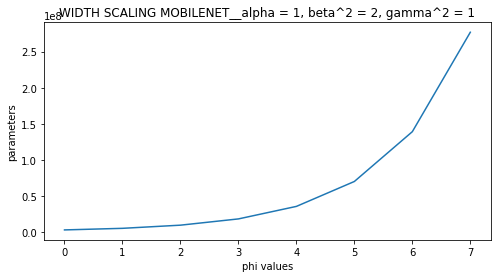

In [64]:
plt.figure(figsize = (8,4)) #plotting results in a graph
plt.title("WIDTH SCALING MOBILENET__alpha = 1, beta^2 = 2, gamma^2 = 1")
plt.xlabel("phi values")
plt.ylabel("parameters")
plt.plot(x_val_mobilenet_width_scaling, y_val_mobilenet_width_scaling)